In [8]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("NiftyStockAnalysis") \
    .getOrCreate()

spark


In [9]:
from pyspark.sql import functions as F


df = spark.read.csv("/home/jovyan/work/data/*.csv", header=True, inferSchema=True)


df.printSchema()
df.show(5)


root
 |-- Date: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Series: string (nullable = true)
 |-- Prev Close: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Last: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VWAP: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Turnover: double (nullable = true)
 |-- Trades: double (nullable = true)
 |-- Deliverable Volume: double (nullable = true)
 |-- %Deliverble: double (nullable = true)

+----------+----------+------+----------+------+------+-----+-----+------+------+--------+-----------------+------+------------------+-----------+
|      Date|    Symbol|Series|Prev Close|  Open|  High|  Low| Last| Close|  VWAP|  Volume|         Turnover|Trades|Deliverable Volume|%Deliverble|
+----------+----------+------+----------+------+------+-----+-----+------+------+--------+-----------------+------+-----

In [10]:
from pyspark.sql.window import Window

# 1. Convert Date column to proper date type
df = df.withColumn("Date", F.to_date("Date", "yyyy-MM-dd"))

# 2. Define window per stock, ordered by Date
window_spec = Window.partitionBy("Symbol").orderBy("Date")

# 3. Previous day's close
df = df.withColumn("Prev_Close", F.lag("Close").over(window_spec))

# 4. Daily return = % change
df = df.withColumn(
    "Daily_Return",
    ((F.col("Close") - F.col("Prev_Close")) / F.col("Prev_Close")) * 100
)


df.select("Date", "Symbol", "Close", "Prev_Close", "Daily_Return").show(10)


+----------+----------+------+----------+-------------------+
|      Date|    Symbol| Close|Prev_Close|       Daily_Return|
+----------+----------+------+----------+-------------------+
|2008-05-26|BAJAJ-AUTO|604.75|      NULL|               NULL|
|2008-05-26|BAJAJ-AUTO|604.75|    604.75|                0.0|
|2008-05-27|BAJAJ-AUTO|593.15|    604.75|-1.9181479950392761|
|2008-05-27|BAJAJ-AUTO|593.15|    593.15|                0.0|
|2008-05-28|BAJAJ-AUTO|608.15|    593.15| 2.5288712804518254|
|2008-05-28|BAJAJ-AUTO|608.15|    608.15|                0.0|
|2008-05-29|BAJAJ-AUTO|599.45|    608.15|-1.4305681164186357|
|2008-05-29|BAJAJ-AUTO|599.45|    599.45|                0.0|
|2008-05-30|BAJAJ-AUTO| 571.7|    599.45|-4.6292434731837515|
|2008-05-30|BAJAJ-AUTO| 571.7|     571.7|                0.0|
+----------+----------+------+----------+-------------------+
only showing top 10 rows



In [11]:

df = df.withColumn("Shock_Day", F.when(F.col("Daily_Return") < -2, 1).otherwise(0))
window_spec = Window.partitionBy("Symbol").orderBy("Date")

df = df.withColumn("Next_Day_Return", F.lead("Daily_Return").over(window_spec))
df = df.withColumn("Bounce_Back", F.when(F.col("Next_Day_Return") > 0, 1).otherwise(0))


df.select("Date", "Symbol", "Close", "Daily_Return", "Shock_Day", "Next_Day_Return", "Bounce_Back").show(15)


+----------+----------+------+--------------------+---------+--------------------+-----------+
|      Date|    Symbol| Close|        Daily_Return|Shock_Day|     Next_Day_Return|Bounce_Back|
+----------+----------+------+--------------------+---------+--------------------+-----------+
|2008-05-26|BAJAJ-AUTO|604.75|                NULL|        0|                 0.0|          0|
|2008-05-26|BAJAJ-AUTO|604.75|                 0.0|        0| -1.9181479950392761|          0|
|2008-05-27|BAJAJ-AUTO|593.15| -1.9181479950392761|        0|                 0.0|          0|
|2008-05-27|BAJAJ-AUTO|593.15|                 0.0|        0|  2.5288712804518254|          1|
|2008-05-28|BAJAJ-AUTO|608.15|  2.5288712804518254|        0|                 0.0|          0|
|2008-05-28|BAJAJ-AUTO|608.15|                 0.0|        0| -1.4305681164186357|          0|
|2008-05-29|BAJAJ-AUTO|599.45| -1.4305681164186357|        0|                 0.0|          0|
|2008-05-29|BAJAJ-AUTO|599.45|                 0.0

In [13]:

df = df.withColumn("Shock_Day", F.when(F.col("Daily_Return") < -2, 1).otherwise(0))

window_spec = Window.partitionBy("Symbol").orderBy("Date")

df = df.withColumn("Next_Day_Return", F.lead("Daily_Return").over(window_spec))

df = df.withColumn("Bounce_Back", F.when(F.col("Next_Day_Return") > 0, 1).otherwise(0))

df.select("Date", "Symbol", "Close", "Daily_Return", "Shock_Day", "Next_Day_Return", "Bounce_Back").show(15)


+----------+----------+------+--------------------+---------+--------------------+-----------+
|      Date|    Symbol| Close|        Daily_Return|Shock_Day|     Next_Day_Return|Bounce_Back|
+----------+----------+------+--------------------+---------+--------------------+-----------+
|2008-05-26|BAJAJ-AUTO|604.75|                NULL|        0|                 0.0|          0|
|2008-05-26|BAJAJ-AUTO|604.75|                 0.0|        0| -1.9181479950392761|          0|
|2008-05-27|BAJAJ-AUTO|593.15| -1.9181479950392761|        0|                 0.0|          0|
|2008-05-27|BAJAJ-AUTO|593.15|                 0.0|        0|  2.5288712804518254|          1|
|2008-05-28|BAJAJ-AUTO|608.15|  2.5288712804518254|        0|                 0.0|          0|
|2008-05-28|BAJAJ-AUTO|608.15|                 0.0|        0| -1.4305681164186357|          0|
|2008-05-29|BAJAJ-AUTO|599.45| -1.4305681164186357|        0|                 0.0|          0|
|2008-05-29|BAJAJ-AUTO|599.45|                 0.0

In [14]:
# Only consider rows that ARE shock days and have a valid next day
shocks = df.filter((F.col("Shock_Day") == 1) & F.col("Next_Day_Return").isNotNull())

overall = shocks.agg(
    F.count("*").alias("num_shocks"),
    F.sum("Bounce_Back").alias("num_bounces"),
    (F.avg(F.col("Bounce_Back")) * 100).alias("bounce_rate_percent")
)

overall.show(truncate=False)


+----------+-----------+-------------------+
|num_shocks|num_bounces|bounce_rate_percent|
+----------+-----------+-------------------+
|32088     |0          |0.0                |
+----------+-----------+-------------------+



In [15]:
per_stock = shocks.groupBy("Symbol").agg(
    F.count("*").alias("num_shocks"),
    F.sum("Bounce_Back").alias("num_bounces"),
    (F.avg("Bounce_Back") * 100).alias("bounce_rate_percent")
).orderBy(F.col("bounce_rate_percent").desc())

print("Top 10 symbols by bounce rate:")
per_stock.show(10, truncate=False)

print("Bottom 10 symbols by bounce rate:")
per_stock.orderBy(F.col("bounce_rate_percent").asc()).show(10, truncate=False)


Top 10 symbols by bounce rate:
+----------+----------+-----------+-------------------+
|Symbol    |num_shocks|num_bounces|bounce_rate_percent|
+----------+----------+-----------+-------------------+
|ASIANPAINT|415       |0          |0.0                |
|AXISBANK  |552       |0          |0.0                |
|ADANIPORTS|324       |0          |0.0                |
|BAJAJFINSV|444       |0          |0.0                |
|BAJAJ-AUTO|291       |0          |0.0                |
|BRITANNIA |404       |0          |0.0                |
|BAJFINANCE|305       |0          |0.0                |
|GAIL      |679       |0          |0.0                |
|BAJAUTOFIN|444       |0          |0.0                |
|HCLTECH   |874       |0          |0.0                |
+----------+----------+-----------+-------------------+
only showing top 10 rows

Bottom 10 symbols by bounce rate:
+----------+----------+-----------+-------------------+
|Symbol    |num_shocks|num_bounces|bounce_rate_percent|
+----------+-

In [16]:
per_stock.coalesce(1).write.mode("overwrite").option("header", True).csv("/home/jovyan/work/output/per_stock_bounce")
overall.coalesce(1).write.mode("overwrite").option("header", True).csv("/home/jovyan/work/output/overall_bounce")


In [17]:

shocks = df.filter((F.col("Shock_Day") == 1) & F.col("Next_Day_Return").isNotNull())


overall = shocks.agg(
    F.count("*").alias("num_shocks"),
    F.sum("Bounce_Back").alias("num_bounces"),
    (F.avg("Bounce_Back") * 100).alias("bounce_rate_percent")
)

overall.show(truncate=False)


+----------+-----------+-------------------+
|num_shocks|num_bounces|bounce_rate_percent|
+----------+-----------+-------------------+
|32088     |0          |0.0                |
+----------+-----------+-------------------+



In [18]:
per_stock = shocks.groupBy("Symbol").agg(
    F.count("*").alias("num_shocks"),
    F.sum("Bounce_Back").alias("num_bounces"),
    (F.avg("Bounce_Back") * 100).alias("bounce_rate_percent")
).orderBy(F.col("bounce_rate_percent").desc())

print("Top 10 symbols by bounce rate:")
per_stock.show(10, truncate=False)

print("Bottom 10 symbols by bounce rate:")
per_stock.orderBy(F.col("bounce_rate_percent").asc()).show(10, truncate=False)


Top 10 symbols by bounce rate:
+----------+----------+-----------+-------------------+
|Symbol    |num_shocks|num_bounces|bounce_rate_percent|
+----------+----------+-----------+-------------------+
|ASIANPAINT|415       |0          |0.0                |
|AXISBANK  |552       |0          |0.0                |
|BAJAJ-AUTO|291       |0          |0.0                |
|BAJAJFINSV|444       |0          |0.0                |
|ADANIPORTS|324       |0          |0.0                |
|BRITANNIA |404       |0          |0.0                |
|CIPLA     |569       |0          |0.0                |
|GAIL      |679       |0          |0.0                |
|BAJAUTOFIN|444       |0          |0.0                |
|HCLTECH   |874       |0          |0.0                |
+----------+----------+-----------+-------------------+
only showing top 10 rows

Bottom 10 symbols by bounce rate:
+----------+----------+-----------+-------------------+
|Symbol    |num_shocks|num_bounces|bounce_rate_percent|
+----------+-

In [20]:
out_base = "/home/jovyan/work/output"

overall.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/overall_bounce.parquet")
overall.toPandas().to_csv(f"{out_base}/overall_bounce.csv", index=False)
per_stock.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/per_stock_bounce.parquet")
per_stock.toPandas().to_csv(f"{out_base}/per_stock_bounce.csv", index=False)

print("Results saved to /output as both CSV and Parquet ")


Results saved to /output as both CSV and Parquet 


In [21]:
import os
print(os.listdir(out_base))


['overall_bounce', 'overall_bounce.csv', 'overall_bounce.parquet', 'per_stock_bounce', 'per_stock_bounce.csv', 'per_stock_bounce.parquet']


In [25]:
per_stock.select("Symbol", "num_shocks", "num_bounces", "bounce_rate_percent").show(20)


+----------+----------+-----------+-------------------+
|    Symbol|num_shocks|num_bounces|bounce_rate_percent|
+----------+----------+-----------+-------------------+
|   HCLTECH|       874|          0|                0.0|
|      BPCL|       872|          0|                0.0|
| ICICIBANK|       869|          0|                0.0|
|     TITAN|       862|          0|                0.0|
|INDUSINDBK|       851|          0|                0.0|
| EICHERMOT|       808|          0|                0.0|
|      SBIN|       788|          0|                0.0|
|TATAMOTORS|       775|          0|                0.0|
|       M&M|       769|          0|                0.0|
|   SESAGOA|       764|          0|                0.0|
|     WIPRO|       731|          0|                0.0|
|       IOC|       731|          0|                0.0|
|      ONGC|       722|          0|                0.0|
|  JSWSTEEL|       708|          0|                0.0|
|  SHREECEM|       704|          0|             

In [29]:
from pyspark.sql import functions as F, Window as W

# Reload & clean
df = (
    spark.read.csv("/home/jovyan/work/data/*.csv", header=True, inferSchema=True)
        .withColumn("Date", F.to_date("Date"))
        .withColumn("Close", F.col("Close").cast("double"))
        .withColumn("Symbol", F.trim(F.col("Symbol")))
        .dropna(subset=["Date","Symbol","Close"])
)

w = W.partitionBy("Symbol").orderBy("Date")

df_feat = (
    df.withColumn("Prev_Close", F.lag("Close").over(w).cast("double"))
      .withColumn("Daily_Return", (F.col("Close") - F.col("Prev_Close")) / F.col("Prev_Close"))
      .withColumn("Shock_Day", F.when(F.col("Daily_Return") <= -0.02, 1).otherwise(0))
      # FIX: compute Next Day *Close*, not return directly
      .withColumn("Next_Close", F.lead("Close").over(w).cast("double"))
      .withColumn("Next_Day_Return", (F.col("Next_Close") - F.col("Close")) / F.col("Close"))
      .withColumn("Bounce_Back", F.when((F.col("Shock_Day")==1) & (F.col("Next_Day_Return") > 0), 1).otherwise(0))
)

# KPIs
overall = df_feat.agg(
    F.sum("Shock_Day").alias("total_shocks"),
    F.sum("Bounce_Back").alias("total_bounces")
).withColumn("bounce_rate_pct", (F.col("total_bounces")/F.col("total_shocks")*100).cast("double"))

per_stock = (
    df_feat.groupBy("Symbol")
           .agg(F.sum("Shock_Day").alias("shock_count"),
                F.sum("Bounce_Back").alias("bounce_count"))
           .withColumn("bounce_rate_pct",
                       F.when(F.col("shock_count")>0,
                              (F.col("bounce_count")/F.col("shock_count")*100).cast("double"))
                        .otherwise(None))
)

# Show quick check
display_overall = overall.toPandas()
display_stock   = per_stock.orderBy(F.desc_nulls_last("bounce_rate_pct")).limit(10).toPandas()

display_overall, display_stock


(   total_shocks  total_bounces  bounce_rate_pct
 0         32089              0              0.0,
        Symbol  shock_count  bounce_count  bounce_rate_pct
 0  ASIANPAINT          415             0              0.0
 1    AXISBANK          552             0              0.0
 2  BAJAJ-AUTO          291             0              0.0
 3  BAJAJFINSV          444             0              0.0
 4  ADANIPORTS          324             0              0.0
 5   BRITANNIA          404             0              0.0
 6       CIPLA          569             0              0.0
 7        GAIL          679             0              0.0
 8  BAJAUTOFIN          444             0              0.0
 9     HCLTECH          874             0              0.0)

In [30]:
sym = "RELIANCE"

sample = (
    df_feat.filter(F.col("Symbol")==sym)
           .select("Date","Close","Prev_Close","Daily_Return",
                   "Shock_Day","Next_Close","Next_Day_Return","Bounce_Back")
           .orderBy("Date")
           .limit(50)   # first 50 rows
           .toPandas()
)

sample


,Date,Close,Prev_Close,Daily_Return,Shock_Day,Next_Close,Next_Day_Return,Bounce_Back
0,2000-01-03,251.70,NaN,NaN,0,251.70,0.000000,0
1,2000-01-03,251.70,251.70,0.000000,0,271.85,0.080056,0
2,2000-01-04,271.85,251.70,0.080056,0,271.85,0.000000,0
3,2000-01-04,271.85,271.85,0.000000,0,282.50,0.039176,0
4,2000-01-05,282.50,271.85,0.039176,0,282.50,0.000000,0
5,2000-01-05,282.50,282.50,0.000000,0,294.35,0.041947,0
6,2000-01-06,294.35,282.50,0.041947,0,294.35,0.000000,0
7,2000-01-06,294.35,294.35,0.000000,0,314.55,0.068626,0
8,2000-01-07,314.55,294.35,0.068626,0,314.55,0.000000,0
9,2000-01-07,314.55,314.55,0.000000,0,308.50,-0.019234,0


In [32]:
from pyspark.sql import functions as F, Window as W


df = (
    spark.read.csv("/home/jovyan/work/data/*.csv", header=True, inferSchema=True)
        .withColumn("Date", F.to_date("Date"))
        .withColumn("Close", F.col("Close").cast("double"))
        .withColumn("Symbol", F.trim(F.col("Symbol")))
        .dropna(subset=["Date","Symbol","Close"])
)

w_dedup = W.partitionBy("Symbol", "Date").orderBy(F.desc("Date"), F.desc("Close"))
df_dedup = (
    df.withColumn("rn", F.row_number().over(w_dedup))
      .filter(F.col("rn") == 1)
      .drop("rn")
)
w = W.partitionBy("Symbol").orderBy("Date")

df_feat = (
    df_dedup
      .withColumn("Prev_Close", F.lag("Close").over(w).cast("double"))
      .withColumn("Daily_Return", (F.col("Close") - F.col("Prev_Close")) / F.col("Prev_Close"))
      .withColumn("Shock_Day", F.when(F.col("Daily_Return") <= -0.02, 1).otherwise(0))
      .withColumn("Next_Close", F.lead("Close").over(w).cast("double"))
      .withColumn("Next_Day_Return", (F.col("Next_Close") - F.col("Close")) / F.col("Close"))
      .withColumn("Bounce_Back", F.when((F.col("Shock_Day")==1) & (F.col("Next_Day_Return") > 0), 1).otherwise(0))
)

overall = df_feat.agg(
    F.sum("Shock_Day").alias("total_shocks"),
    F.sum("Bounce_Back").alias("total_bounces")
).withColumn("bounce_rate_pct", F.round(F.col("total_bounces")/F.col("total_shocks")*100, 2))

per_stock = (
    df_feat.groupBy("Symbol")
           .agg(F.sum("Shock_Day").alias("shock_count"),
                F.sum("Bounce_Back").alias("bounce_count"))
           .withColumn("bounce_rate_pct",
                       F.round(
                           F.when(F.col("shock_count")>0,
                                  (F.col("bounce_count")/F.col("shock_count")*100))
                           .otherwise(None), 2))
)

display_overall = overall.toPandas()
display_stock   = per_stock.orderBy(F.desc_nulls_last("bounce_rate_pct")).limit(10).toPandas()

sym = "RELIANCE"
sample_shocks = (
    df_feat.filter((F.col("Symbol")==sym) & (F.col("Shock_Day")==1))
           .select("Date","Close","Prev_Close","Daily_Return","Next_Close","Next_Day_Return","Bounce_Back")
           .orderBy("Date")
           .limit(12)
           .toPandas()
)

display_overall, display_stock, sample_shocks


(   total_shocks  total_bounces  bounce_rate_pct
 0         32089          16192            50.46,
        Symbol  shock_count  bounce_count  bounce_rate_pct
 0        INFY          176           100            56.82
 1   POWERGRID          295           165            55.93
 2        SSLT           63            35            55.56
 3       TELCO          207           115            55.56
 4    JSWSTEEL          708           393            55.51
 5       CIPLA          569           310            54.48
 6  BAJFINANCE          305           165            54.10
 7         ITC          535           287            53.64
 8         TCS          409           219            53.55
 9   KOTAKBANK          611           326            53.36,
           Date   Close  Prev_Close  Daily_Return  Next_Close  Next_Day_Return  \
 0   2000-01-11  288.50      308.50     -0.064830      301.70         0.045754   
 1   2000-01-17  308.75      316.30     -0.023870      314.20         0.017652   
 2   

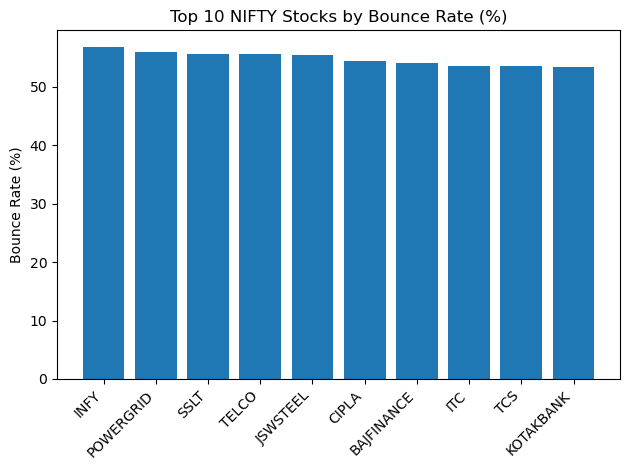

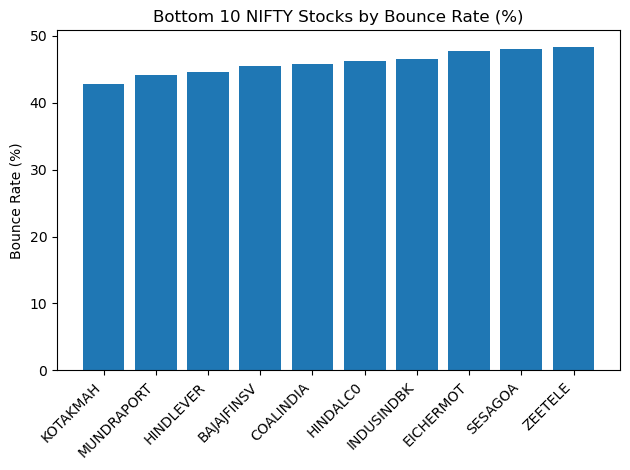

In [35]:
import matplotlib.pyplot as plt

top10 = per_stock.orderBy(F.desc_nulls_last("bounce_rate_pct")).limit(10).toPandas()

plt.figure()
plt.bar(top10["Symbol"], top10["bounce_rate_pct"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 NIFTY Stocks by Bounce Rate (%)")
plt.ylabel("Bounce Rate (%)")
plt.tight_layout()
plt.show()

bot10 = per_stock.filter("shock_count > 0") \
                 .orderBy(F.asc_nulls_last("bounce_rate_pct")) \
                 .limit(10).toPandas()

plt.figure()
plt.bar(bot10["Symbol"], bot10["bounce_rate_pct"])
plt.xticks(rotation=45, ha="right")
plt.title("Bottom 10 NIFTY Stocks by Bounce Rate (%)")
plt.ylabel("Bounce Rate (%)")
plt.tight_layout()
plt.show()


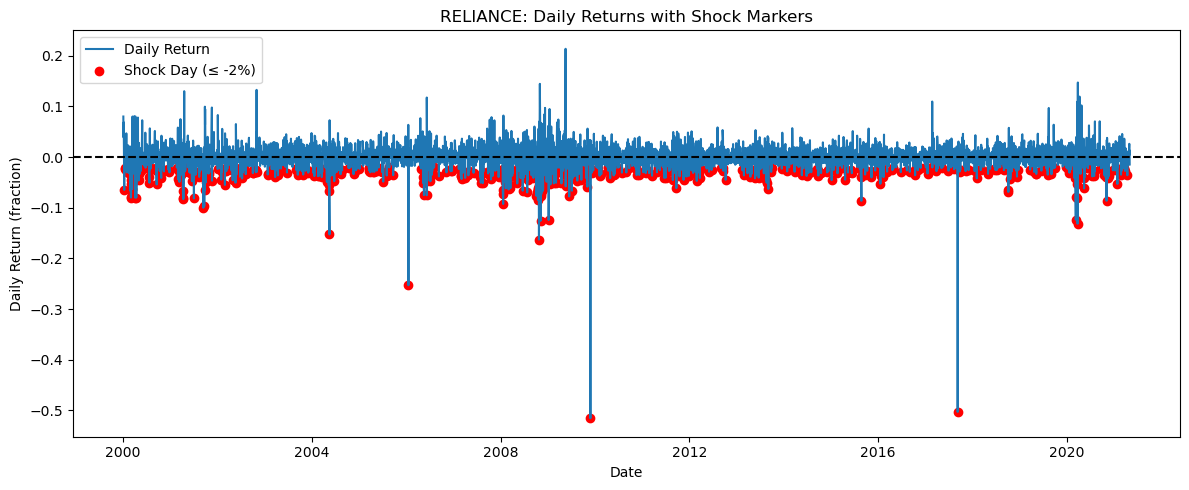

In [36]:
sym = "RELIANCE" 
sdf = (
    df_feat.filter(F.col("Symbol")==sym)
           .select("Date","Daily_Return","Shock_Day")
           .orderBy("Date")
           .toPandas()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(sdf["Date"], sdf["Daily_Return"], label="Daily Return")
plt.scatter(
    sdf.loc[sdf["Shock_Day"]==1, "Date"],
    sdf.loc[sdf["Shock_Day"]==1, "Daily_Return"],
    color="red", marker="o", label="Shock Day (≤ -2%)"
)
plt.axhline(0, color="black", linestyle="--")
plt.title(f"{sym}: Daily Returns with Shock Markers")
plt.ylabel("Daily Return (fraction)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
!pip install streamlit



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 12.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.7 MB/s eta 0:00:00


In [41]:
!ls -lah /home/jovyan/work/output


total 4.0K
drwxrwxrwx 1 root   root  4.0K Sep 20 06:17 .
drwxrwxrwx 1 root   root  4.0K Sep 19 20:13 ..
-rw-r--r-- 1 jovyan users   69 Sep 20 05:59 kpi.json
drwxr-xr-x 1 jovyan users 4.0K Sep 19 19:11 overall_bounce
-rw-r--r-- 1 jovyan users   55 Sep 20 05:59 overall_bounce.csv
drwxr-xr-x 1 jovyan users 4.0K Sep 20 06:17 overall_bounce_csv
drwxr-xr-x 1 jovyan users 4.0K Sep 20 06:17 overall_bounce.parquet
drwxr-xr-x 1 jovyan users 4.0K Sep 19 19:11 per_stock_bounce
-rw-r--r-- 1 jovyan users 1.2K Sep 20 05:59 per_stock_bounce.csv
drwxr-xr-x 1 jovyan users 4.0K Sep 20 06:17 per_stock_bounce_csv
drwxr-xr-x 1 jovyan users 4.0K Sep 20 06:17 per_stock_bounce.parquet


In [42]:
overall = spark.read.parquet("/home/jovyan/work/output/overall_bounce.parquet").toPandas()
per_stock = spark.read.parquet("/home/jovyan/work/output/per_stock_bounce.parquet").toPandas()


In [2]:
!pip install streamlit



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 13.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00


In [3]:
import streamlit as st
print("Streamlit version:", st.__version__)


Streamlit version: 1.49.1


In [3]:
# ---------- CONFIG ----------
DATA_DIR = "/home/jovyan/work/data"
OUT      = "/home/jovyan/work/output"

# Thresholds
SHOCK_DROP = -0.02   # a day with return <= -2% is a "shock"
BOUNCE_UP  =  0.005  # next day >= +0.5% counts as a "bounce"

# ---------- IMPORTS ----------
import os, glob
import numpy as np
import pandas as pd

os.makedirs(OUT, exist_ok=True)

# ---------- LOAD & CLEAN ----------
files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
if not files:
    raise FileNotFoundError(f"No CSVs found in {DATA_DIR}")

dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df["Date"] = pd.to_datetime(df["Date"])
df["Prev Close"] = pd.to_numeric(df["Prev Close"], errors="coerce")
df["Close"]      = pd.to_numeric(df["Close"],      errors="coerce")
df = df.dropna(subset=["Prev Close","Close"])

df["Daily_Return"] = (df["Close"] - df["Prev Close"]) / df["Prev Close"]

# Next day return per symbol
df = df.sort_values(["Symbol","Date"])
df["Next_Day_Return"] = df.groupby("Symbol")["Daily_Return"].shift(-1)

# Shock / Bounce flags
df["is_shock"]  = (df["Daily_Return"] <= SHOCK_DROP)
df["is_bounce"] = df["is_shock"] & (df["Next_Day_Return"] >= BOUNCE_UP)

# ---------- OVERALL & PER-STOCK ----------
total_shocks  = int(df["is_shock"].sum())
total_bounce  = int(df["is_bounce"].sum())
bounce_rate   = (total_bounce / total_shocks * 100.0) if total_shocks > 0 else 0.0

overall = pd.DataFrame([{
    "num_shocks": total_shocks,
    "num_bounces": total_bounce,
    "bounce_rate_percent": bounce_rate
}])
overall.to_csv(os.path.join(OUT, "overall_bounce.csv"), index=False)

per_stock = (df.groupby("Symbol", as_index=False)
               .agg(num_shocks=("is_shock","sum"),
                    num_bounces=("is_bounce","sum")))
per_stock["bounce_rate_percent"] = np.where(
    per_stock["num_shocks"] > 0,
    per_stock["num_bounces"] / per_stock["num_shocks"] * 100.0,
    0.0
)
per_stock = per_stock.sort_values("bounce_rate_percent", ascending=False)
per_stock.to_csv(os.path.join(OUT, "per_stock_bounce.csv"), index=False)

# ---------- SHOCK EVENTS (for distributions/table) ----------
shock_events = df.loc[df["is_shock"], ["Symbol","Date","Daily_Return","Next_Day_Return"]].copy()
shock_events.sort_values(["Symbol","Date"], inplace=True)
shock_events.to_csv(os.path.join(OUT, "shock_events.csv"), index=False)

# ---------- EVENT STUDY (avg return from -5..+5 around shocks) ----------
# Build shifted returns per symbol: ret_-k = previous day, ret_+k = next day
df = df.copy()
offsets = list(range(-5, 6))
for k in offsets:
    if k < 0:
        df[f"ret_{k}"] = df.groupby("Symbol")["Daily_Return"].shift(abs(k))   # previous days
    elif k > 0:
        df[f"ret_{k}"] = df.groupby("Symbol")["Daily_Return"].shift(-k)      # future days
    else:
        df[f"ret_{k}"] = df["Daily_Return"]

# Take only shock rows, compute mean for each offset
ev = df.loc[df["is_shock"], [f"ret_{k}" for k in offsets]].copy()
means = {k: ev[f"ret_{k}"].mean(skipna=True) for k in offsets}
event_mean = pd.DataFrame({"offset": list(means.keys()),
                           "mean_return": list(means.values())}).sort_values("offset")
event_mean.to_csv(os.path.join(OUT, "event_study_mean.csv"), index=False)

# ---------- SIMPLE BACKTEST: buy shock, sell next day ----------
eq = shock_events[["Date","Next_Day_Return"]].sort_values("Date").copy()
eq["equity"] = (1.0 + eq["Next_Day_Return"].fillna(0)).cumprod()
eq.to_csv(os.path.join(OUT, "equity_curve.csv"), index=False)

print("Wrote:")
print(" - overall_bounce.csv")
print(" - per_stock_bounce.csv")
print(" - shock_events.csv")
print(" - event_study_mean.csv")
print(" - equity_curve.csv")


Wrote:
 - overall_bounce.csv
 - per_stock_bounce.csv
 - shock_events.csv
 - event_study_mean.csv
 - equity_curve.csv


In [6]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

# Load
raw = spark.read.csv("/home/jovyan/work/data/*.csv", header=True, inferSchema=True)

# Minimal clean + de-dup per Symbol/Date
df = (
    raw.select(
        F.col("Symbol"),
        F.to_date("Date", "yyyy-MM-dd").alias("Date"),
        F.col("Close").cast("double").alias("Close"),
        F.col("Prev Close").cast("double").alias("Prev_Close")
    )
    .dropna(subset=["Prev_Close","Close"])
)

w_dupe = W.partitionBy("Symbol","Date").orderBy(F.desc("Close"))
df = df.withColumn("rn", F.row_number().over(w_dupe)).filter("rn = 1").drop("rn")

# Returns
df = df.withColumn("Daily_Return", (F.col("Close")/F.col("Prev_Close") - 1.0))

# Next-day close & next-day return (this is the bounce test)
w = W.partitionBy("Symbol").orderBy("Date")
df = df.withColumn("Next_Close", F.lead("Close").over(w))
df = df.withColumn("Next_Close_Return", (F.col("Next_Close")/F.col("Close") - 1.0))

# Shock and bounce flags
shocks = (
    df.filter(F.col("Daily_Return") <= -0.02)
      .withColumn("Bounce_Back", (F.col("Next_Close_Return") > 0).cast("int"))
)

# Print a quick summary ONLY
shocks.select(
    F.count("*").alias("num_shocks"),
    F.sum("Bounce_Back").alias("num_bounces"),
    (F.avg(F.col("Bounce_Back").cast("double"))*100).alias("bounce_rate_percent")
).show(truncate=False)


+----------+-----------+-------------------+
|num_shocks|num_bounces|bounce_rate_percent|
+----------+-----------+-------------------+
|32094     |16196      |50.484710576353606 |
+----------+-----------+-------------------+



In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NIFTY Shock Bounce Analysis") \
    .getOrCreate()


In [8]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

# 1) If you don't already have these, compute returns + next-day return
w = W.partitionBy("Symbol").orderBy("Date")
df = (
    df  # your cleaned de-duplicated df with Symbol, Date, Prev_Close, Close
    .withColumn("Daily_Return", (F.col("Close")/F.col("Prev_Close")) - 1)
    .withColumn("Next_Close", F.lead("Close").over(w))
    .withColumn("Next_Close_Return", (F.col("Next_Close")/F.col("Close")) - 1)
)

# 2) Shock & bounce flags
shock_cond  = F.col("Daily_Return") <= -0.02
bounce_cond = F.col("Next_Close_Return") >= 0

df2 = (
    df
    .withColumn("Shock", F.when(shock_cond, 1).otherwise(0))
    .withColumn("Bounce_Back", F.when(shock_cond & bounce_cond, 1).otherwise(0))
)

# 3) Per-stock metrics
per_stock = (
    df2.groupBy("Symbol")
       .agg(
           F.sum("Shock").alias("shock_count"),
           F.sum("Bounce_Back").alias("bounce_count")
       )
       .withColumn("bounce_rate_pct", (F.col("bounce_count")/F.col("shock_count"))*100)
)

per_stock.orderBy(F.col("bounce_rate_pct").desc()).show(20, truncate=False)



+----------+-----------+------------+------------------+
|Symbol    |shock_count|bounce_count|bounce_rate_pct   |
+----------+-----------+------------+------------------+
|INFY      |176        |101         |57.38636363636363 |
|POWERGRID |295        |169         |57.28813559322033 |
|SSLT      |63         |35          |55.55555555555556 |
|TELCO     |207        |115         |55.55555555555556 |
|JSWSTEEL  |708        |393         |55.50847457627118 |
|CIPLA     |569        |311         |54.6572934973638  |
|ITC       |535        |290         |54.20560747663551 |
|BAJAUTOFIN|444        |240         |54.054054054054056|
|BAJFINANCE|306        |165         |53.92156862745098 |
|TCS       |409        |220         |53.789731051344745|
|KOTAKBANK |611        |328         |53.682487725040914|
|BHARTIARTL|524        |280         |53.43511450381679 |
|HINDALCO  |674        |358         |53.11572700296736 |
|RELIANCE  |625        |331         |52.959999999999994|
|HINDUNILVR|255        |135    

In [10]:
out_base = "/home/jovyan/work/output"

# --- Save per_stock (Spark DataFrame) ---
per_stock.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/per_stock.parquet")
per_stock.toPandas().to_csv(f"{out_base}/per_stock.csv", index=False)

# --- Save overall (already Pandas DataFrame) ---
import pandas as pd

overall.to_parquet(f"{out_base}/overall.parquet", index=False)
overall.to_csv(f"{out_base}/overall.csv", index=False)

print("Results saved to /home/jovyan/work/output/")



Results saved to /home/jovyan/work/output/


In [11]:
import os
print(os.listdir(out_base))


['data_quality_report.json', 'equity_curve.csv', 'event_study_mean.csv', 'kpi.json', 'overall.csv', 'overall.parquet', 'overall_bounce', 'overall_bounce.csv', 'overall_bounce.parquet', 'overall_bounce_csv', 'per_stock.csv', 'per_stock.parquet', 'per_stock_bounce', 'per_stock_bounce.csv', 'per_stock_bounce.parquet', 'per_stock_bounce_csv', 'shock_events.csv']


In [12]:
import pandas as pd

# Load saved per_stock
per_stock_df = pd.read_parquet("/home/jovyan/work/output/per_stock.parquet")
print(per_stock_df.head(10))

# Load saved overall
overall_df = pd.read_parquet("/home/jovyan/work/output/overall.parquet")
print(overall_df)


       Symbol  shock_count  bounce_count  bounce_rate_pct
0  BAJAJ-AUTO          292           153        52.397260
1       CIPLA          569           311        54.657293
2    HDFCBANK          503           250        49.701789
3   HEROHONDA          437           224        51.258581
4    HINDALCO          674           358        53.115727
5   ICICIBANK          869           429        49.367089
6        INFY          176           101        57.386364
7          LT          518           251        48.455598
8         M&M          769           376        48.894668
9     SESAGOA          764           370        48.429319
   num_shocks  num_bounces  bounce_rate_percent
0       64186        13322            20.755305


In [14]:
!pip install duckdb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 11.9 MB/s eta 0:00:0000:0100:01


In [18]:
import duckdb

con = duckdb.connect("/home/jovyan/work/output/market.duckdb")

# Register parquet files
con.execute("CREATE OR REPLACE TABLE per_stock AS SELECT * FROM read_parquet('/home/jovyan/work/output/per_stock.parquet')")
con.execute("CREATE OR REPLACE TABLE overall AS SELECT * FROM read_parquet('/home/jovyan/work/output/overall.parquet')")


top10 = con.execute("""
    SELECT Symbol, shock_count, bounce_count, bounce_rate_pct
    FROM per_stock
    ORDER BY bounce_rate_pct DESC
    LIMIT 10
""").fetchdf()

print(top10)


       Symbol  shock_count  bounce_count  bounce_rate_pct
0        INFY          176           101        57.386364
1   POWERGRID          295           169        57.288136
2       TELCO          207           115        55.555556
3        SSLT           63            35        55.555556
4    JSWSTEEL          708           393        55.508475
5       CIPLA          569           311        54.657293
6         ITC          535           290        54.205607
7  BAJAUTOFIN          444           240        54.054054
8  BAJFINANCE          306           165        53.921569
9         TCS          409           220        53.789731


In [17]:
!ps aux | grep duckdb



jovyan   20672 15.0  0.0   7368  3200 pts/4    Ss+  15:17   0:00 /bin/bash -c ps aux | grep duckdb
jovyan   20674  0.0  0.0   6476  2304 pts/4    S+   15:17   0:00 grep duckdb
